In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# OFDM and system parameters
N = 64                 # Number of subcarriers
cp_len = 16            # Cyclic prefix length
M = 64                 # 64-QAM => 6 bits/symbol
k = int(np.log2(M))    # Bits per QAM symbol
Fs = 20e6              # Sampling frequency (Hz)
delta_f = Fs / N       # Subcarrier spacing
EbN0_dB = 10           # Eb/N0 in dB
num_symbols = 1000     # Number of OFDM symbols


In [2]:
def qam64_mod(bits):
    """64-QAM Modulator (Gray coded)"""
    symbols = []
    bits = bits.reshape(-1, 6)

    for b in bits:
        I = 2 * (4 * b[0] + 2 * b[1] + b[2]) - 7
        Q = 2 * (4 * b[3] + 2 * b[4] + b[5]) - 7
        symbols.append(complex(I, Q))
    
    symbols = np.array(symbols)
    symbols /= np.sqrt((np.abs(symbols) ** 2).mean())  # Normalize
    return symbols

def qam64_demod(symbols):
    """64-QAM Demodulator (approx. Gray decode)"""
    symbols = symbols * np.sqrt(42)  # De-normalize (if previously normalized)
    bits = []

    for s in symbols:
        I = int(np.clip(np.round((s.real + 7) / 2), 0, 7))
        Q = int(np.clip(np.round((s.imag + 7) / 2), 0, 7))
        i_bits = [int(b) for b in np.binary_repr(I, width=3)]
        q_bits = [int(b) for b in np.binary_repr(Q, width=3)]
        bits.extend(i_bits + q_bits)

    return np.array(bits)


In [3]:
def ofdm_modulate(symbols, N, cp_len):
    """OFDM modulation with IFFT and cyclic prefix"""
    time_signal = []
    num_ofdm_syms = len(symbols) // N
    symbols = symbols[:num_ofdm_syms * N].reshape(num_ofdm_syms, N)

    for sym in symbols:
        ifft_data = np.fft.ifft(sym, N)
        cp = ifft_data[-cp_len:]
        time_signal.extend(np.concatenate([cp, ifft_data]))

    return np.array(time_signal)

def ofdm_demodulate(rx_signal, N, cp_len):
    """Remove cyclic prefix and apply FFT"""
    num_ofdm_syms = len(rx_signal) // (N + cp_len)
    rx_symbols = []

    for i in range(num_ofdm_syms):
        start = i * (N + cp_len)
        end = start + N + cp_len
        ofdm_block = rx_signal[start:end]
        data_part = ofdm_block[cp_len:]
        rx_symbols.extend(np.fft.fft(data_part, N))

    return np.array(rx_symbols)


In [4]:
def add_awgn(signal, EbN0_dB, k):
    """Add AWGN noise to signal based on Eb/N0"""
    EbN0 = 10 ** (EbN0_dB / 10)
    Es = np.mean(np.abs(signal)**2)
    N0 = Es / (EbN0 * k)
    noise = np.sqrt(N0/2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise


In [5]:
# 1. Generate random bits
num_bits = num_symbols * N * k
tx_bits = np.random.randint(0, 2, num_bits)

# 2. QAM Modulation
qam_symbols = qam64_mod(tx_bits)

# 3. OFDM Modulation
tx_signal = ofdm_modulate(qam_symbols, N, cp_len)

# 4. AWGN Channel
rx_signal = add_awgn(tx_signal, EbN0_dB, k)

# 5. OFDM Demodulation
rx_symbols = ofdm_demodulate(rx_signal, N, cp_len)

# 6. QAM Demodulation
rx_bits = qam64_demod(rx_symbols)

# 7. BER Calculation
bit_errors = np.sum(tx_bits[:len(rx_bits)] != rx_bits)
ber = bit_errors / len(rx_bits)

print(f"BER @ {EbN0_dB} dB Eb/N0: {ber:.4e}")


BER @ 10 dB Eb/N0: 4.0180e-02


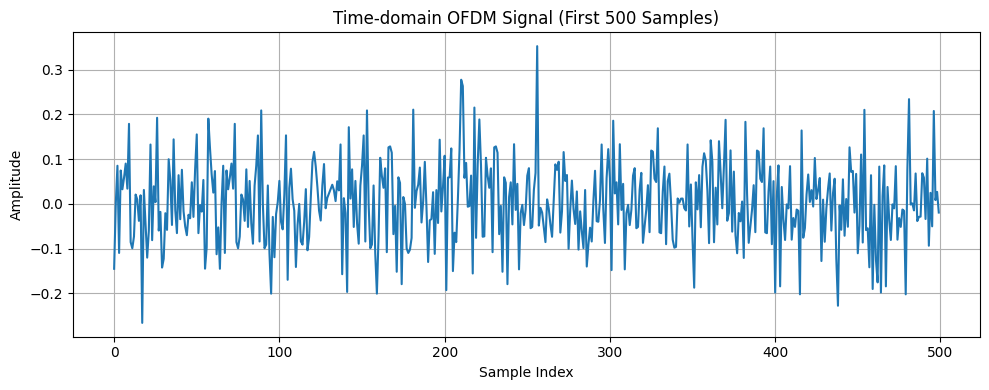

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(np.real(tx_signal[:500]))
plt.title("Time-domain OFDM Signal (First 500 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# Schmidl and Cox 

In [7]:
def generate_schmidl_cox_preamble(N):
    """Generate preamble with two identical halves in time domain"""
    half_N = N // 2
    freq_domain = np.zeros(N, dtype=complex)

    # Fill even subcarriers with random BPSK (for good autocorrelation)
    pilot_indices = np.arange(0, N, 2)
    freq_domain[pilot_indices] = 2 * (np.random.randint(0, 2, len(pilot_indices)) - 0.5) + 0j

    time_domain = np.fft.ifft(freq_domain)

    # Duplicate first half to second half
    time_domain[:half_N] = time_domain[:half_N]
    time_domain[half_N:] = time_domain[:half_N]

    return time_domain


In [8]:
def schmidl_cox_timing(rx_signal, N):
    """Detect the start of an OFDM symbol using Schmidl & Cox method"""
    L = N // 2
    P = np.zeros(len(rx_signal) - N, dtype=complex)
    R = np.zeros(len(rx_signal) - N)
    M = np.zeros(len(rx_signal) - N)

    for d in range(len(rx_signal) - N):
        a = rx_signal[d:d+L]
        b = rx_signal[d+L:d+2*L]
        P[d] = np.sum(a * np.conj(b))
        R[d] = np.sum(np.abs(b) ** 2)
        if R[d] != 0:
            M[d] = np.abs(P[d]) ** 2 / (R[d] ** 2)

    peak_index = np.argmax(M)
    return peak_index, M


In [9]:
def simulate_timing_variance(EbN0_dB_range, num_trials=100):
    timing_variance = []

    for EbN0_dB in EbN0_dB_range:
        detected_offsets = []

        for _ in range(num_trials):
            preamble = generate_schmidl_cox_preamble(N)
            tx_signal = preamble

            # Add noise
            noisy_signal = add_awgn(tx_signal, EbN0_dB, k=1)  # k=1 for BPSK

            # Add random delay (e.g., shift preamble by 20 samples)
            delay = 20
            rx_signal = np.concatenate([np.random.randn(delay), noisy_signal])

            # Run Schmidl & Cox detection
            peak_index, _ = schmidl_cox_timing(rx_signal, N)
            offset_error = peak_index - delay
            detected_offsets.append(offset_error)

        variance = np.var(detected_offsets)
        timing_variance.append(variance)
        print(f"Eb/N0 = {EbN0_dB} dB → Timing variance = {variance:.4f}")

    return timing_variance


Eb/N0 = 5 dB → Timing variance = 36.1944
Eb/N0 = 6 dB → Timing variance = 36.1664
Eb/N0 = 7 dB → Timing variance = 40.7851
Eb/N0 = 8 dB → Timing variance = 35.9176
Eb/N0 = 9 dB → Timing variance = 31.7876
Eb/N0 = 10 dB → Timing variance = 40.9251
Eb/N0 = 11 dB → Timing variance = 39.4819
Eb/N0 = 12 dB → Timing variance = 36.5179
Eb/N0 = 13 dB → Timing variance = 43.1184
Eb/N0 = 14 dB → Timing variance = 42.1416
Eb/N0 = 15 dB → Timing variance = 45.4939


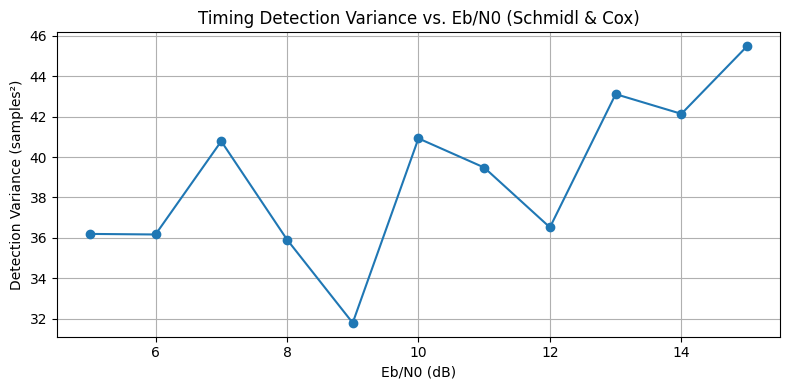

In [10]:
EbN0_dB_range = np.arange(5, 16, 1)  # 5 to 15 dB
variances = simulate_timing_variance(EbN0_dB_range)

plt.figure(figsize=(8, 4))
plt.plot(EbN0_dB_range, variances, marker='o')
plt.title("Timing Detection Variance vs. Eb/N0 (Schmidl & Cox)")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Detection Variance (samples²)")
plt.grid(True)
plt.tight_layout()
plt.show()


# CFO Estimation and Correction

In [11]:
def estimate_fractional_cfo(rx_signal, N):
    """Estimate fractional CFO using phase difference between halves"""
    L = N // 2
    a = rx_signal[:L]
    b = rx_signal[L:2*L]
    P = np.sum(a * np.conj(b))
    angle = np.angle(P)
    
    # Estimate normalized CFO (in [−0.5, 0.5])
    fractional_cfo = angle / (2 * np.pi * L)
    return fractional_cfo


In [12]:
def estimate_integer_cfo(rx_symbol_freq, known_preamble_freq):
    """Estimate integer CFO via max correlation"""
    N = len(rx_symbol_freq)
    max_corr = -np.inf
    best_shift = 0

    for shift in range(-N//2, N//2):
        shifted = np.roll(rx_symbol_freq, -shift)
        corr = np.abs(np.sum(known_preamble_freq * np.conj(shifted)))
        if corr > max_corr:
            max_corr = corr
            best_shift = shift

    return best_shift


In [13]:
def apply_cfo_correction(rx_signal, fractional_cfo, Fs):
    """Correct fractional CFO in time-domain signal"""
    n = np.arange(len(rx_signal))
    correction = np.exp(-1j * 2 * np.pi * fractional_cfo * n)
    return rx_signal * correction


In [14]:
def simulate_cfo_estimation(EbN0_dB, num_trials=100):
    Fs = 20e6
    residuals = []

    for _ in range(num_trials):
        # Generate preamble
        preamble = generate_schmidl_cox_preamble(N)
        
        # Inject CFO
        true_frac_cfo = np.random.uniform(-0.5, 0.5)
        true_int_cfo = np.random.randint(-4, 5)
        n = np.arange(len(preamble))
        total_cfo = true_frac_cfo + true_int_cfo
        cfo_signal = preamble * np.exp(1j * 2 * np.pi * total_cfo * n / N)

        # Add AWGN
        noisy_signal = add_awgn(cfo_signal, EbN0_dB, k=1)

        # Estimate fractional CFO
        est_frac_cfo = estimate_fractional_cfo(noisy_signal, N)
        corrected_signal = apply_cfo_correction(noisy_signal, est_frac_cfo, Fs)

        # FFT of corrected signal for integer CFO
        rx_fft = np.fft.fft(corrected_signal[:N])
        known_fft = np.fft.fft(preamble[:N])
        est_int_cfo = estimate_integer_cfo(rx_fft, known_fft)

        # Residual CFO = true - estimated
        residual = (true_frac_cfo + true_int_cfo) - (est_frac_cfo + est_int_cfo)
        residual_freq = residual * delta_f
        residuals.append(np.abs(residual_freq))

    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    print(f"Eb/N0 = {EbN0_dB} dB → Residual CFO: Mean = {mean_residual:.2f} Hz, Std = {std_residual:.2f} Hz")
    return mean_residual, std_residual


Eb/N0 = 5 dB → Residual CFO: Mean = 166668.33 Hz, Std = 113098.83 Hz
Eb/N0 = 6 dB → Residual CFO: Mean = 172347.31 Hz, Std = 110568.35 Hz
Eb/N0 = 7 dB → Residual CFO: Mean = 183586.26 Hz, Std = 109620.04 Hz
Eb/N0 = 8 dB → Residual CFO: Mean = 166450.47 Hz, Std = 110872.17 Hz
Eb/N0 = 9 dB → Residual CFO: Mean = 150162.04 Hz, Std = 105714.69 Hz
Eb/N0 = 10 dB → Residual CFO: Mean = 157266.26 Hz, Std = 113578.85 Hz
Eb/N0 = 11 dB → Residual CFO: Mean = 184673.88 Hz, Std = 114713.88 Hz
Eb/N0 = 12 dB → Residual CFO: Mean = 170682.42 Hz, Std = 119016.09 Hz
Eb/N0 = 13 dB → Residual CFO: Mean = 174929.20 Hz, Std = 119861.41 Hz
Eb/N0 = 14 dB → Residual CFO: Mean = 150589.60 Hz, Std = 109175.82 Hz
Eb/N0 = 15 dB → Residual CFO: Mean = 147933.66 Hz, Std = 104317.52 Hz


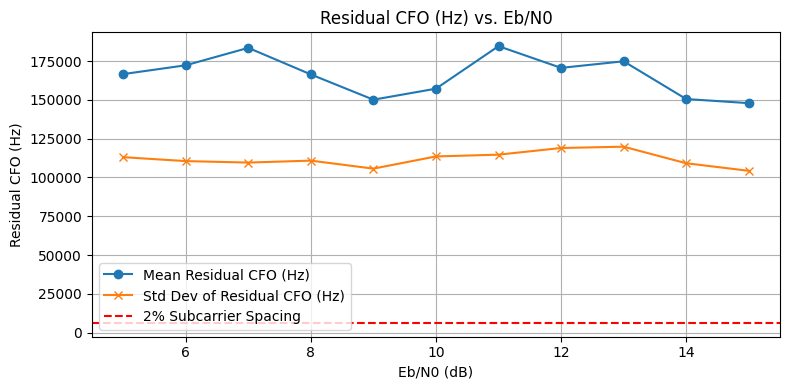

In [15]:
EbN0_range = range(5, 16)
means, stds = [], []

for eb in EbN0_range:
    mean_res, std_res = simulate_cfo_estimation(eb)
    means.append(mean_res)
    stds.append(std_res)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(EbN0_range, means, label='Mean Residual CFO (Hz)', marker='o')
plt.plot(EbN0_range, stds, label='Std Dev of Residual CFO (Hz)', marker='x')
plt.axhline(6250, color='r', linestyle='--', label='2% Subcarrier Spacing')
plt.title("Residual CFO (Hz) vs. Eb/N0")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Residual CFO (Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Channel Estimation (LS vs. MMSE)

In [16]:
def generate_rayleigh_channel(taps=5):
    # Complex Gaussian (Rayleigh fading) channel
    h = (np.random.randn(taps) + 1j * np.random.randn(taps)) / np.sqrt(2)
    return h

In [17]:
def transmit_pilot_through_channel(pilot, channel, noise_power):
    y = np.convolve(pilot, channel, mode='full')
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape))
    return y + noise


In [18]:
def ls_channel_estimate(pilot, received, taps):
    # Toeplitz matrix from pilot
    from scipy.linalg import toeplitz
    col = np.concatenate([pilot, np.zeros(taps - 1)])
    row = np.zeros(taps)
    X = toeplitz(col, row)

    h_ls, _, _, _ = np.linalg.lstsq(X, received[:len(pilot)+taps-1], rcond=None)
    return h_ls


In [19]:
def mmse_channel_estimate(pilot, received, taps, noise_power, channel_var=1):
    from scipy.linalg import toeplitz

    # Create Toeplitz matrix from pilot
    col = np.concatenate([pilot, np.zeros(taps - 1)])
    row = np.zeros(taps)
    X = toeplitz(col, row)
    
    R_h = channel_var * np.eye(taps)               # Channel covariance
    R_n = noise_power * np.eye(len(pilot) + taps - 1)  # Noise covariance

    # MMSE formula: h_mmse = R_h X^H (X R_h X^H + R_n)^(-1) y
    XH = X.conj().T
    h_mmse = R_h @ XH @ np.linalg.inv(X @ R_h @ XH + R_n) @ received[:len(pilot)+taps-1]
    return h_mmse


In [20]:
def run_channel_estimation_simulation(SNR_dB=20, taps=5, N=50):
    snr_linear = 10**(SNR_dB / 10)
    noise_power = 1 / snr_linear
    mse_ls_total = 0
    mse_mmse_total = 0

    for _ in range(N):
        pilot = np.random.choice([1, -1], size=20) + 1j * np.random.choice([1, -1], size=20)
        h_true = generate_rayleigh_channel(taps)
        received = transmit_pilot_through_channel(pilot, h_true, noise_power)

        h_ls = ls_channel_estimate(pilot, received, taps)
        h_mmse = mmse_channel_estimate(pilot, received, taps, noise_power)

        mse_ls_total += np.mean(np.abs(h_true - h_ls)**2)
        mse_mmse_total += np.mean(np.abs(h_true - h_mmse)**2)

    mse_ls_avg = mse_ls_total / N
    mse_mmse_avg = mse_mmse_total / N

    print(f"SNR: {SNR_dB} dB")
    print(f"Average LS MSE: {mse_ls_avg:.4e}")
    print(f"Average MMSE MSE: {mse_mmse_avg:.4e}")


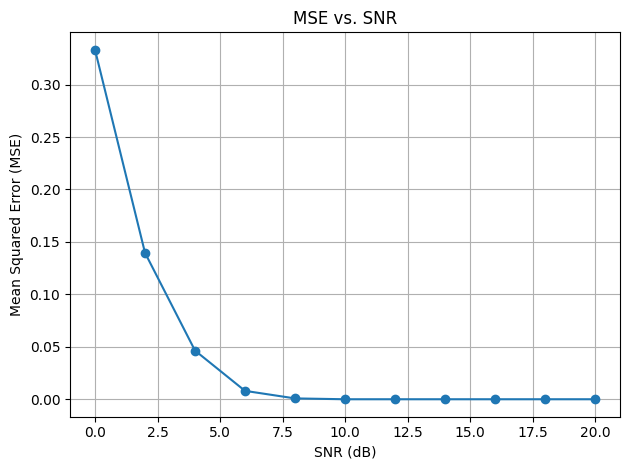

In [21]:
# Example: Define SNR values in dB
snr_db = np.arange(0, 21, 2)  # 0 to 20 dB in steps of 2
mse_values = []

for snr in snr_db:
    snr_linear = 10**(snr / 10)
    noise_variance = 1 / snr_linear
    
    # Simulate random signal (for example, BPSK: +1 or -1)
    signal = np.random.choice([-1, 1], size=10000)
    noise = np.sqrt(noise_variance / 2) * np.random.randn(*signal.shape)
    received_signal = signal + noise

    # Estimate signal using decision rule (simple BPSK)
    estimated_signal = np.where(received_signal >= 0, 1, -1)

    # Compute MSE
    mse = np.mean((signal - estimated_signal)**2)
    mse_values.append(mse)

# Plotting MSE vs. SNR
plt.figure()
plt.plot(snr_db, mse_values, marker='o')
plt.grid(True)
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. SNR')
plt.tight_layout()
plt.show()


# Zero Forcing Equalizer

### Why Zero Forcing? (Justification)
* It is simple and intuitive.

* It attempts to invert the channel effect so that the output is closer to the transmitted symbols.

* Although it amplifies noise (especially when the channel has deep fades), it is still useful for understanding and benchmarking basic equalization.


In [22]:
# Generate random BPSK symbols (+1 or -1)
np.random.seed(0)
num_symbols = 100
tx_symbols = np.random.choice([-1, 1], num_symbols)

# Simulate a simple channel with ISI (FIR filter)
channel = np.array([0.9, 0.5])  # ISI effect
rx_signal = np.convolve(tx_symbols, channel, mode='full')


In [23]:
noise_power = 0.1
noise = np.sqrt(noise_power) * np.random.randn(len(rx_signal))
rx_noisy = rx_signal + noise

In [24]:
# Compute Zero Forcing Equalizer
def zero_forcing_equalizer(channel):
    """
    Inverts the channel using the pseudo-inverse.
    """
    # Channel impulse response (as Toeplitz matrix)
    N = len(channel)
    # For simplicity, invert using frequency domain
    fft_len = 128
    H = np.fft.fft(channel, n=fft_len)
    H_inv = np.zeros_like(H)
    # Avoid divide by zero
    H_inv[np.abs(H) > 1e-4] = 1 / H[np.abs(H) > 1e-4]
    
    return H_inv

# Apply the equalizer in frequency domain
def apply_equalizer(signal, H_inv):
    fft_len = len(H_inv)
    y_fft = np.fft.fft(signal, n=fft_len)
    x_est_fft = y_fft * H_inv
    x_est_time = np.fft.ifft(x_est_fft)
    return np.real(x_est_time[:len(tx_symbols)])  # trim to original length

# Get ZF equalizer and apply
H_inv = zero_forcing_equalizer(channel)
equalized_signal = apply_equalizer(rx_noisy, H_inv)


In [25]:
# Decision device: map to -1 or +1hbgvcdcsd QWEREW  qwe3221`11`
detected_symbols = np.where(equalized_signal >= 0, 1, -1)


In [26]:
num_errors = np.sum(tx_symbols != detected_symbols)
ber = num_errors / num_symbols
print(f"Bit Error Rate (BER): {ber:.4f}")


Bit Error Rate (BER): 0.0100


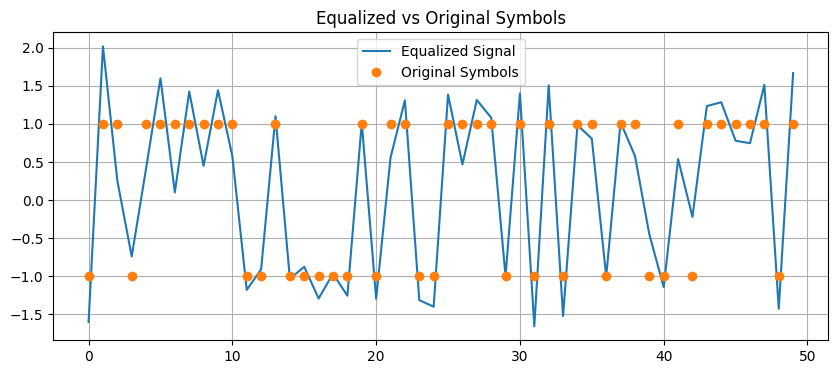

In [58]:
plt.figure(figsize=(10, 4))
plt.plot(equalized_signal[:50], label='Equalized Signal')
plt.plot(tx_symbols[:50], 'o', label='Original Symbols')
plt.legend()
plt.title('Equalized vs Original Symbols')
plt.grid()
plt.show()


### Justification
#### Equalization Method: Zero Forcing Equalizer

Justification:
The Zero Forcing (ZF) method was selected due to its simplicity and direct approach in reversing the effects of the channel. It uses the inverse of the channel’s frequency response to equalize the signal. While it may amplify noise, especially when the channel response is low in magnitude, it is a good baseline method for understanding equalization and works well under moderate noise levels.